##### Dataset for Movies: Potts, Christopher. 2011. On the negativity of negation. In Nan Li and David Lutz, eds., Proceedings of Semantics and Linguistic Theory 20, 636-659.

http://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
# Import Movie dataset (previously joined together using csv format)
import pandas as pd
df = pd.read_csv('/Users/cesarosorio/anaconda/aclImdb/movie_data.csv')
df.head(5)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


#### Cleaning the data

In [2]:
# Cleanning the MOvie data
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + \
           ' '.join(emoticons).replace('-', '')
    return text

df['review'] = df['review'].apply(preprocessor)

In [3]:
# Transform the dataframe to a sparse Tdidf matrix
#from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Now we create the sparse matrix of tfidf values
tfidf = TfidfVectorizer(input='content',stop_words='english',ngram_range=(1, 1),min_df=400, max_df=0.80)
# max_df at 80% just eliminates 11 very frequent words
# i chose min_df=400 because it is just 0.8% of 50000 reviews, 
# deletes 98% of  words that are infrequent or 98,000 words.
# Stopwords deletes ~300 words more
dtm = tfidf.fit_transform([c for c in df['review']])
vocab = np.array(tfidf.get_feature_names())
dtm = dtm.toarray()  # convert to a regular array
vocab = np.array(vocab)
dtm.shape

(50000, 1921)

In [4]:
dtm[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [4]:
# Create training and test set 
# in a reasonable time
y_class = df.loc[:, 'sentiment'].values
n_break= 40000
n_final=50000
X_train = dtm[:n_break]
y_train = y_class[:n_break]
X_test = dtm[n_break:n_final]
y_test = y_class[n_break:n_final]
print(X_train.shape,X_test.shape)

(40000, 1921) (10000, 1921)


#### Neural Networks

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import pydot_ng
from IPython.display import Image
from IPython.display import SVG
from sklearn.preprocessing import scale
import timeit
from time import time

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


##Movie data

## Original data
train_y = y_train.astype(np.int32)
test_y = y_test.astype(np.int32)
train_X = scale(X_train).astype(np.float32)
test_X = scale(X_test).astype(np.float32)


# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = train_X.shape[1] # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality (2 for Movie data and 4 for Wine data)
nn_hdim = 3 # hiden layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [7]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 100 iterations
train_errorsNN = []
test_errorsNN = []
num_passes= 2000
def build_model(num_passes=num_passes, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
            #print("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))
            train_errorsNN.append(1. - np.mean(predict(train_X)==train_y))
            test_errorsNN.append(1. - np.mean(predict(test_X)==test_y))
  

# Build a model with a n-dimensional hidden layer

t0 = time()
build_model(print_loss=True)
print("done in %0.3fs." % (time() - t0))

done in 899.647s.


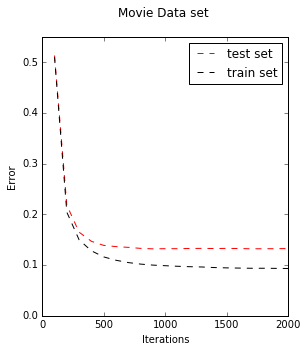

In [9]:
n_trees_real = num_passes


plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(100, n_trees_real +1,100),
         test_errorsNN, c='red',
         linestyle='dashed', label='test set')

plt.plot(range(100, n_trees_real + 1, 100),
         train_errorsNN, c='black',
         linestyle='dashed', label='train set')


plt.legend(loc='upper right')
plt.ylim(0, 0.55)
plt.xlim(0, 2000)
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.title('Movie Data set \n', fontsize=12, ha='center')

In [17]:
print(min(test_errorsNN),min(train_errorsNN))

0.132 0.093225


In [27]:
dtm[0][400:420]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.0855211 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.10440102,  0.        ,  0.        ,  0.        ])

In [28]:
vocab[400:420]

array(['date', 'dated', 'daughter', 'david', 'day', 'days', 'dead', 'deal',
       'dealing', 'deals', 'death', 'debut', 'decade', 'decent', 'decide',
       'decided', 'decides', 'decision', 'deep', 'deeply'], 
      dtype='<U14')

#### Using Doc2Vec to obtain additional features for the NN model (to go beyond 86.8% accuracy)

In [6]:
#y_class = df.loc[:, 'sentiment'].values
#n_break= 40000
#n_final=50000
#y_train = y_class[:n_break]
#y_test = y_class[n_break:n_final]
X_d2v = df['review'][:n_break]
X_d2v_test = df['review'][n_break:n_final]
print(X_d2v.shape,X_d2v_test.shape)

(40000,) (10000,)


In [7]:
token_review=[]
for i in range(df['review'].shape[0]):
    review = df['review'][i]
    token_review.append([i for i in review.split()])

len(token_review)

50000

In [8]:
import gensim
LabeledSentence = gensim.models.doc2vec.LabeledSentence
    
def labelizeReviews(reviews, label_type):
    labelized = []
    for i,v in enumerate(reviews):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [9]:
sentence=labelizeReviews(token_review, "SENT")
len(sentence)

50000

In [10]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from gensim import utils
from time import time

# assumptions: window is 8 words left and right, eliminate words than dont occur in
# more than 5 sentences, use 4 workers for a quadcore machine. Size is the size of vector
#model = Doc2Vec(sentence, size=100, window=8, workers=4, min_count=5)
#model.train(sentence)

import random

size = 100

#instantiate our DM and DBOW models
model_dm = Doc2Vec(min_count=5, window=8, size=size, sample=1e-3, negative=5, workers=4)
#model_dbow = Doc2Vec(min_count=5, window=8, size=size, sample=1e-3, negative=5, dm=0, workers=4)

#build vocab over all reviews
model_dm.build_vocab(sentence)
#model_dbow.build_vocab(sentence)

#We pass through the data set multiple times, shuffling the training reviews each time to improve accuracy.
Idx=list(range(len(sentence)))

t0 = time()
for epoch in range(20):
     random.shuffle(Idx)
     perm_sentences = [sentence[i] for i in Idx]
     model_dm.train(perm_sentences)
     #print(epoch)
    
elapsed=time() - t0
print("Time taken for Doc2vec training: ", elapsed, "seconds.")

Time taken for Doc2vec training:  243.51225304603577 seconds.


In [38]:
model_dm.most_similar('bad')

[('good', 0.7883749008178711),
 ('lousy', 0.7355077266693115),
 ('horrible', 0.7184992432594299),
 ('lame', 0.7100013494491577),
 ('terrible', 0.698971152305603),
 ('poor', 0.698810338973999),
 ('stupid', 0.6958223581314087),
 ('awful', 0.6575497388839722),
 ('crappy', 0.6443665027618408),
 ('weak', 0.6411662101745605)]

In [12]:
sims = model_dm.docvecs.most_similar(0)
sims

[('SENT_27689', 0.723747730255127),
 ('SENT_42290', 0.7038084268569946),
 ('SENT_33466', 0.7035574913024902),
 ('SENT_43204', 0.7020452618598938),
 ('SENT_31316', 0.7013808488845825),
 ('SENT_32185', 0.6936382055282593),
 ('SENT_41827', 0.690937876701355),
 ('SENT_32828', 0.6889008283615112),
 ('SENT_4176', 0.6883151531219482),
 ('SENT_47235', 0.684755265712738)]

In [13]:
model_dm.docvecs[39999]

array([-0.05064727, -0.25283319,  0.17083608, -0.10996772, -0.0430305 ,
       -0.01842013, -0.05075447,  0.07611655,  0.00473158,  0.07783382,
       -0.19585735,  0.04891584,  0.20574255, -0.14435893, -0.01531711,
        0.11219973, -0.2721853 ,  0.14868011,  0.0634122 ,  0.17671943,
        0.16983531,  0.18497667,  0.17713387,  0.08080573, -0.10790437,
       -0.01389934,  0.19194293, -0.0377558 ,  0.38202107,  0.14378253,
       -0.22441521,  0.00084104, -0.15350206,  0.01024183,  0.19337861,
       -0.03595914,  0.05866024, -0.1935425 , -0.38218465,  0.05150442,
       -0.12860949, -0.05100375, -0.28356582, -0.23388085, -0.2164485 ,
       -0.00898302,  0.09565073,  0.35905534,  0.17599414, -0.02534359,
       -0.18531923,  0.02199774,  0.1675231 ,  0.04712206,  0.12579554,
        0.08482923,  0.00882371,  0.00244154, -0.22593951, -0.2381904 ,
       -0.07116814,  0.07031343, -0.11439206, -0.05388721,  0.09523781,
       -0.02243849, -0.06859057, -0.13150413, -0.18219995, -0.14

#### Running new NN model with doc2vec info ONLY

In [137]:
#y_class = df.loc[:, 'sentiment'].values
#n_break= 40000
#n_final=50000
#y_train = y_class[:n_break]
#y_test = y_class[n_break:n_final]

In [14]:
X_train_d2v = np.zeros((n_break, size))

for i in range(len(X_train_d2v)):
    X_train_d2v[i] = model_dm.docvecs[i]
    
X_test_d2v = np.zeros((n_final - n_break, size))

for i in range(n_final - n_break):
    X_test_d2v[i] = model_dm.docvecs[i+n_break]

print(X_train_d2v.shape ,X_test_d2v.shape )

(40000, 100) (10000, 100)


In [15]:
X_train_d2v.shape

(40000, 100)

#### Neural Network Model with doc2vec

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import pydot_ng
from IPython.display import Image
from IPython.display import SVG
from sklearn.preprocessing import scale
import timeit
from time import time

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


##Movie data

## Original data
train_y = y_train.astype(np.int32)
test_y = y_test.astype(np.int32)
train_X = scale(X_train_d2v).astype(np.float32)
test_X = scale(X_test_d2v).astype(np.float32)


# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = train_X.shape[1] # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality (2 for Movie data and 4 for Wine data)
nn_hdim = 3 # hiden layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [188]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 100 iterations
train_errorsNN = []
test_errorsNN = []
num_passes= 2000
def build_model(num_passes=num_passes, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
            #print("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))
            train_errorsNN.append(1. - np.mean(predict(train_X)==train_y))
            test_errorsNN.append(1. - np.mean(predict(test_X)==test_y))
  

# Build a model with a n-dimensional hidden layer

t0 = time()
build_model(print_loss=True)
print("done in %0.3fs." % (time() - t0))

done in 34.975s.


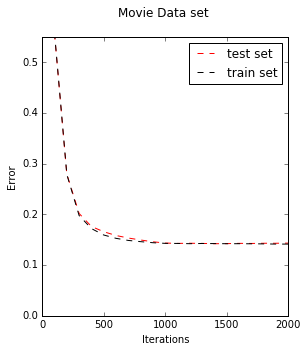

In [189]:
n_trees_real = num_passes


plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(100, n_trees_real +1,100),
         test_errorsNN, c='red',
         linestyle='dashed', label='test set')

plt.plot(range(100, n_trees_real + 1, 100),
         train_errorsNN, c='black',
         linestyle='dashed', label='train set')


plt.legend(loc='upper right')
plt.ylim(0, 0.55)
plt.xlim(0, 2000)
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.title('Movie Data set \n', fontsize=12, ha='center')

In [143]:
# without scaling doc2vec features
print(min(test_errorsNN),min(train_errorsNN))

0.161 0.157075


In [190]:
#  scaling doc2vec features: better results
print(min(test_errorsNN),min(train_errorsNN))

0.1421 0.141375


#### Now run the mode using both "bag of words' and 'doc2vec' info

In [16]:
X_train_total=np.concatenate((X_train,X_train_d2v), axis=1)
X_test_total=np.concatenate((X_test,X_test_d2v), axis=1)
print(X_train_total.shape,X_test_total.shape)

(40000, 2021) (10000, 2021)


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import pydot_ng
from IPython.display import Image
from IPython.display import SVG
from sklearn.preprocessing import scale
import timeit
from time import time

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


##Movie data

## All features: Bag of words and Doc2vec
train_y = y_train.astype(np.int32)
test_y = y_test.astype(np.int32)
train_X = scale(X_train_total).astype(np.float32)
test_X = scale(X_test_total).astype(np.float32)


# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = train_X.shape[1] # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality 
nn_hdim = 3 # hiden layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Let Theano calculate the derivatives for us
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [18]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 100 iterations
train_errorsNN = []
test_errorsNN = []
num_passes= 2000
def build_model(num_passes=num_passes, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
            #print("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))
            train_errorsNN.append(1. - np.mean(predict(train_X)==train_y))
            test_errorsNN.append(1. - np.mean(predict(test_X)==test_y))
  

# Build a model with a n-dimensional hidden layer

t0 = time()
build_model(print_loss=True)
print("done in %0.3fs." % (time() - t0))

done in 930.063s.


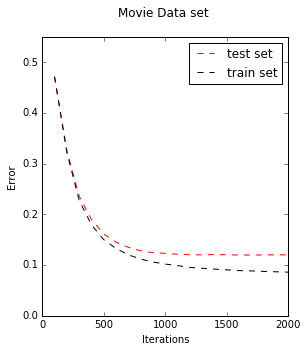

In [19]:
n_trees_real = num_passes


plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(100, n_trees_real +1,100),
         test_errorsNN, c='red',
         linestyle='dashed', label='test set')

plt.plot(range(100, n_trees_real + 1, 100),
         train_errorsNN, c='black',
         linestyle='dashed', label='train set')


plt.legend(loc='upper right')
plt.ylim(0, 0.55)
plt.xlim(0, 2000)
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.title('Movie Data set \n', fontsize=12, ha='center')

In [20]:
## we acchieved 11.76% error rate in the test set or 88.24% accuracy 
## combining 'bag of words' and 'doc2vec'
print(min(test_errorsNN),min(train_errorsNN))

0.1198 0.08605


#### End of test

In [183]:
model_dm.infer_vector(['in',
 '1974',
 'the',
 'teenager',
 'martha',
 'moxley',
 'maggie',
 'grace',
 'moves',
 'to'], alpha=0.1, min_alpha=0.0001, steps=5)

array([ 0.00529616, -0.0409766 ,  0.03171283, -0.07810711, -0.01102173,
        0.04823575,  0.080281  ,  0.00776164,  0.04004049,  0.00835915,
        0.05199156,  0.10039654, -0.04732696,  0.04031415,  0.08352556,
       -0.02692998, -0.01525104,  0.01838643, -0.00789196,  0.00479145,
        0.00375875, -0.02157798, -0.01444479,  0.02319912, -0.06565878,
        0.00153875,  0.1004648 , -0.01404935, -0.01676909,  0.07490442,
       -0.00159302, -0.05919391,  0.05486324, -0.05916072, -0.08205521,
       -0.00627669,  0.06990162,  0.00859309, -0.03177552, -0.01206181,
        0.00017519,  0.02085466, -0.0329023 ,  0.00559636, -0.07610828,
       -0.05323493,  0.005262  , -0.03459534, -0.0195877 ,  0.02589849,
        0.03540355, -0.01379014,  0.06419075,  0.00893575, -0.03896128,
       -0.02212084, -0.01503388, -0.00480019,  0.02036769, -0.02925434,
       -0.05345323, -0.07111195,  0.0361684 ,  0.07475515,  0.02861479,
        0.04350529, -0.03231478, -0.04608748,  0.03181088,  0.03

In [185]:
model_dm.infer_vector(sentence[0].words, alpha=0.1, min_alpha=0.0001, steps=5).shape

(100,)

In [33]:
build_model

<function __main__.build_model>

In [36]:
# saves the doc2vec model to be used later.
model_dm.save('./model_doc2vec')

In [ ]:
import pickle
import os

dest = os.path.join('movieclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)